# HPA Workshop: Tasmanian Devil Cancer Analysis

Welcome to this workshop!

In the process of this session, you will:
* Get hands-on experience working processing some real cancer data
* Have a basic introduction to supervised neural networks
* * Play around with different ways to get information into the network
* Be introduced to some un-supervised techniques for anomaly detection


There is a lot of text and explanations on this notebook - you can process them at your own speeds (or ignore them entirely). The following key is used:
1. Text in black is background information
2. <font color='red'>**Text in red is a task you should complete**</font>
3. <font color='blue'>**Text in blue is a question to think about as a group**</font>

## Quick Recap: Tasmanian Devils

To briefly recap Zemin's presentation:
1. Tasmanian Devils suffer from a form of transmissible cancer, which gives them 'Devil Facial Disease' (DFTD)
2. This cancer shows signs of `chromothripsis', a catastrophic genomic rearrangement
3. In addition to rearrangement, there are signs of large scale deletions and duplications of sections of the DNA
4. Chromothripsis shows similar patterns in other forms of cancer; human oesophogeal and prostate cancer, for example
## Our Goals

Our research (and your task today) is to find a way to classify and study this cancer -- in the hope that we may then extend it from this easier case<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) to studying the more complex forms.

To do this, we must first:
1. Label the data (this has been done for us!)
2. Process the data into useable form
3. Set-up and then train a Neural Network Classifier
4. Utilise some form of un-supervised methods to detect variations that are not contained within our labels




<a name="cite_note-1"></a>1. [^](#cite_ref-1) Tasmanian Devils went through a genetic bottleneck (hence the transmissible cancer), and so they are all genetically very similar. This makes their genomes relatively homogeneous with respect to one another

## Coverage Data
Let's first look at some coverage data. 

It helps to first understand why duplications/deletions result in coverage variations:

<img src="Images/coverageExplain.png" />

### Our Data

The raw datafiles for several Tasmanian Devils is found in the Data directory. We have given the Devils human names to aid in communication.

((List some known Devils so they can browse))

When we come to do this for real, we would work on the entire genome at once. However, for ease of use we have pre-selected the portions of interest to us. The datafiles represent a `super chromosome' formed by joining Chromosomes 4 and 5 into one long chain. This is an artifice to make this workshop run easier!


<font color='red'>**Run the code below, varying the dataThinning values and the data until you feel that you have a handle on the data**</font>

<font color='red'>We have provided a small subset of the data for you to choose from:
1. `Abigail.dat`
2. `Diane.dat`
3. `Travis.dat`
4. `Elmer.dat`
5. `Vern.dat`
6. `Arthur.dat`

These are all Tasmanian Devils - some with cancer, some without.

There is also another dataset in there -- `Human.dat` -- this is a human oesophageal cancer sample.</font>

In [ ]:
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import deforest
file = "Data/Human.dat"

dataThinning = 0.999 #This value controls the level of smoothing applied to the data. 0 is the raw data, 0.99(etc) is very smooth.
baseSkipping = 1000 #This value controls the base-sampling rate. Higher values makes the later code run quicker, but uses less information
s = deforest.DataStruct(file,dataThinning,baseSkipping) #We have provided an inbuilt data-parser for you, because we're nice.

plt.figure(1)
plt.clf() #comment this out if you do want to layer multiple plots
plt.plot(s.Index,s.Coverage)
plt.ylabel("Coverage")
plt.xlabel("Chromosome Index")
plt.show(1)

<font color=blue>**Can you identify the differences between these samples?**</font>

<font color=blue>**What problems can you think we might have to overcome, in order to get this data into a form useable for machine learning?**</font>



## The Deforester

To overcome some of these problems, we have developed the *deforester*, a Bayesian inference algorithm which:
1. Determines the overall per-homolog coverage rate
2. Finds the most likely positions for 'transitions'
3. Encodes those transitions into a feature vector of variable length

The key thing which makes *deforester* work is the knowledge that 'a transition' (i.e. a duplication or deletion event) should (assuming no subclonality) result in a coverage variation which is an **integer multiple of the per-homolog coverage rate**; we then draw analogies between the resonant frequencies ('harmonics') observed in musical instruments to create a powerful statistical machinery.

The code takes three main parameters:
1. The assumed statistical distribution of the model
2. The maximum harmonic considered (this is purely a computational limit; the code runs quicker with this value smaller, but is more accurate with it larger!)
3. The *smallest permitted jump*. This prevents the code from spuriously identifying small variations: we know (for example) that the affected regions must be larger than the read length to be detected via this method (else the alignment tool would catch it)

<font color=red>**Explore the features of the provided probability distribution, and try coming up with your own**</font>

<font color=red>*Your probability distribution function should:*
1. *Be a function of the average coverage value (nu) and the measured coverage value of a given base (k)*
2. *Be negative everywhere (probabilities are less than 1, and this is a log-probability)*
3. *Not necessarily sum to 1 (the code self-normalises)*
4. *Not do anything weird like got to negative infinity*
5. *Be as weird as you like, the purpose of this is to demonstrate how varying the distribution function affects the output!*
</font>

In [ ]:
def jackLogProbability(k,nu):
	#This is a (somewhat) biologically motivated distribution function, which assumes that the distribution is Poisson 
	#distributed around the norm, but with some statistical noise distributed according to the Gamma distribution; which 
	#in turn means the distribution is a Negative Binomial distribution. 
	#Then on *top* of that, I add a secondary noise term which is just a big gaussian 
	#background noise centred on nu - representing a general background uncertainty in everything
	
	fractionOfDataWhichIsReal = 0.99
	dataNoise = 3
	backgroundNoise = 5
	return deforest.dualBinomial(k,nu,fractionOfDataWhichIsReal,dataNoise,backgroundNoise)

def myLogProbability(k,nu):
	sigma = 5 
	return -0.5 * ((k-nu)/sigma)**2  #this is just a boring Gaussian that I put down. You make up your own function. Get weird.

nu = 45
k = np.arange(0,100)

plt.figure(2)
plt.clf()
plt.plot(k,jackLogProbability(k,nu),label="Biological Function")
plt.plot(k,myLogProbability(k,nu),label="My Function")
plt.xlabel("Observed Coverage")
plt.legend()
plt.ylabel(f"Log-Probability with Mean {nu}")
plt.show()

## Running Deforester

The deforester algorithm uses a network-navigation based approach to ensure that the predicted harmonics are the globally most-likely set, subject to the following constraints:
* Each base in the sequence is a 'layer' in the network, which the q^th node being being associated with the q^th harmonic
* If the final minimum-distance path passes through the q^th node in the i^th layer, then the i^th base is said to have a harmonic of q 
* Assigning a base with observed coverage `k` to the `q`th harmonic incurs a penalty equal to `myProbabilityFunction(k,q*nu)`, where `nu` is an inferred fundamental frequency
* `nu` is determined by doing a rapid parameter search with resolution `SearchResolution`
* A harmonic transition cannot occur within a distance `minimumJump` from another harmonic transition
* The harmonic cannot exceed `maxHarmonic`
* A penalty of `LogJumpPrior` is applied every time a harmonic transition is applied
* A penalty of `LogDiploidPrior` is applied to every base which does not have a harmonic of 2<a name="cite_ref-2"></a>[<sup>[1]</sup>](#cite_note-2)



<a name="cite_note-2"></a>1. [^](#cite_ref-2) Because we are only looking at a subset of the Devil Genome which is badly affected by cancer, we have actually reduced this requirement for this workshop. We only apply the penalty to harmonics which are not 2, 3 or 4

<font color=red>**Run the deforester algorithm on a dataset of your choice - vary the parameters of the model, and see how that affects the outcome**</font>

<font color=blue>**How does this help us achieve our goals? What was the purpose of this exercise?**</font>

Navigation complete. 75123 nodes navigated in 8.47982382774353 seconds.
Maximum Score was -223054.46589601488


[]

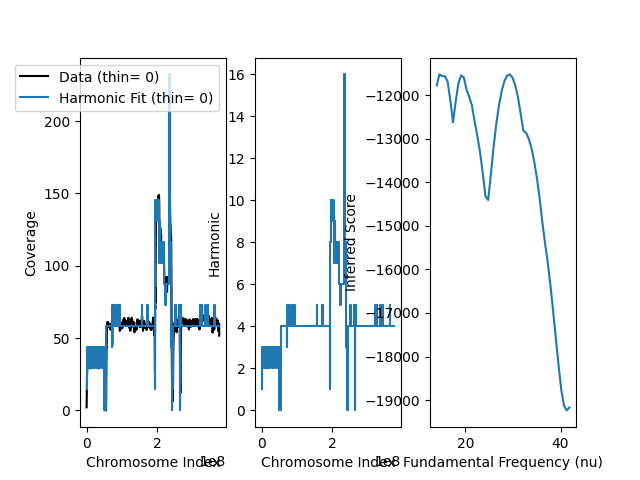

In [29]:
file = "Data/Human.dat"

preSmoothing = 0
dataSkip = 5000 #if you are running on the web hosted version (it's very slow!)
# dataSkip = 500 #if you are running locally
maxHarmonic = 16
minimumJump = 1e6


s = deforest.DataStruct(file,preSmoothing,dataSkip)
sPlot = deforest.DataStruct(file,0.999,dataSkip) #load a smoothed version for plotting!

N = deforest.Network(maxHarmonic,minimumJump)
N.LogJumpPrior = -50 #Set this to zero to permit more jumps, set to a large negative value (< -1000) to remove jumps that the code is less certain about
N.LogDiploidPrior = -0.1 #Set this to zero to disable the Diploid Prior (for maximum impact, also increase maxHarmonic to see what happens!)
N.SearchResolution = 50 # Turn this value down to make it faster, but too low and your results become nonsense as nu cannot accurately be determined
optimalPath = N.Navigate(s,myLogProbability)



## Now we plot the model
fig,axs = plt.subplots(1,3)
axs[0].plot(sPlot.Index,sPlot.Coverage,'k',label="Data (thin= " + str(preSmoothing) + ")")
[xx,yy] = optimalPath.GetPlottingPath(s) 
axs[0].plot(xx,yy,label="Harmonic Fit (thin= " + str(preSmoothing) + ")")
axs[0].legend()
axs[0].set_xlabel("Chromosome Index")
axs[0].set_ylabel("Coverage")
axs[1].plot(xx,yy/optimalPath.Nu)
axs[1].set_xlabel("Chromosome Index")
axs[1].set_ylabel("Harmonic")
axs[2].plot(N.nus,N.scores)
axs[2].set_xlabel("Fundamental Frequency (nu)")
axs[2].set_ylabel("Inferred Score")
plt.plot()

## Encoding

Having extracted the most important features, we now turn to encoding this information into a *feature vector*, of length `N`. 

<font color=blue>**Why is it important to be able to specify `N`?**</font>

For the sake of simplicity, we have provided 3 different ways to encode the information. All three work by segmenting the chromosome into `N` equal parts (and expressing the chromosome index as a fraction along the chromosome - a value between 0 and 1).

1. Method one (`diff`) computes the value of $\sum_i (q_{i-1} - q_{i+1})$ of every transition in that segment. It therefore counts the 'net jumps' between the sample values.
2. Method two (`sum`) computes the value of $\sum_i |q_{i-1} - q_{i+1}|$ of every transition in that segment. The absolute value ensures that a jump from `q=1` to `q=2`, back to `q=1` scores a value of 2, rather than 0 (as `diff` would score it)
3. Method three (`sqdiff`) computes the value of $\sum_i (q_{i-1} - q_{i+1})^2$ across the segment. 

<font color=blue>**What benefits do these different encodings bring? Why might one be better than the other? Can you think of your own, better encoding?**</font>

<font color=red>**Try generating the encoding for your chosen datafile -- vary the resolution and see if your earlier guesses hold up.**</font>

*I will note that there does seem to be something odd about the behaviour of `sqdiff`, it doesn't seem to do what I thought it did (the values are smaller than `sum` which shouldn't be the case!) -- I spotted it too late to correct for this presentation, is it still encoding the relevant information, despite this error?* 


In [ ]:
fig,axs=plt.subplots(1,3)
modes = ['diff','sum','sqdiff']
for i in range(len(modes)):
	enc = optimalPath.Encode(s,N.JumpSize,modes[i],10)
	axs[i].plot(np.linspace(0,1,len(enc)),enc)
	axs[i].set_title(modes[i])
plt.show()

# Machine Learning

Onto the exciting bit!

Now that we have a rigorous method for turning coverage datafiles into encoded feature vectors, we are going to attempt to build a neural network classifier which can tell us the probability that a provided encoding falls into one of three categories: non-cancerous (category 0), type-1 DFTD (category 1), or type-2 DFTD (category 2).  

We will first do this using a **supervised** method. A supervised classifier 'trains' itself by using a pre-labelled dataset. 

We have provided a number of different such datasets, in the `ProcessedData` repository. These contain 172 other Tasmanian Devils (**the 6 Tasmanian Devils you have data for are not included in this sample**).

1. `AllData` includes 172 Tasmanian Devils processed using `deforester` with 45 different parameter combinations
2. `HighConfidence` is a subset of 20 parameter combinations of `AllData`, where the probability model is *not* dominated by the background noise
3. `BigGap` is a subset of 8 parameter combinations of `HighConfidence` where the `minimumJump` value is larger than 1 million bases
4. `SmallGap` is the corresponding subset of 12 parameter combinations where `minimumJump` is smaller than 1 million bases

For each of these subsets there are then a number of different encodings, at a number of different resolutions - varying from 10-dimensional, to 1000-dimensional.

<font color=blue>**Why do we have so many different options? What is the purpose of the multiple parameter models? Which do you expect to perform the best? What is the difference between validation data and training data?**</font>


<font color=red>**Choose the datafile you are going to train, and examine the feature and label vectors**</font>

In [ ]:
def loadTrainingData(file,trainingFraction,mode=0):

	load_x = []
	load_y = []
	with open(file) as f:
		for line in f:	
			vals = line.rstrip().split(' ')
			x = []

			## if you want to get fancy, you can additionally provide the network with the deforester parameters which were used to generate it
			## uncomment these lines to add three dimensions to your feature vector -- but remember that you'll need to do that for your encoding later on!
			# params = vals[0].split('_')
			# gap = int(params[1])
			# noise = float(params[2])/10000
			# sigma = float(params[3])
			# x = [gap,noise,sigma]
			for i in range(2,len(vals)):
				x.append(float(vals[i]))
			tag = int(vals[1])			
			load_x.append(x)
			load_y.append(tag)
	N = len(load_x)
	p = np.random.permutation(N)
	load_x = np.array(load_x)[p]
	load_y = np.array(load_y)[p]

	trainN  = int(trainingFraction*N)

	return (load_x[:trainN],load_y[:trainN]), (load_x[trainN:],load_y[trainN:])

trainingFile = "ProcessedData/AllData/Res_100_sum.dat"
(x_train, y_train), (x_test, y_test) = loadTrainingData(trainingFile,0.5,0)

## Creating the network

For the case of a simple classifier, we are going to construct a very basic Feedforward Neural Network. 

As a reminder of how an FNN functions:
1. The network is split into a series of *layers*
2. Each layer contains a series of nodes
3. Each layer:
	1. Takes an input vector
	2. Performs a non-linear transformation on it (determined by the *weights* of the layer, and the activation function)
	3. Outputs another vector. The dimension of the output vector is equal to the number of *nodes* in the *layer*
4. The layers take the vector given to them by the layer below, transform it, and pass it on to the next layer.
5. The act of 'training' the network is optimising the weights of all of the nodes, in order to minimise an 'objective function'

We will use the tensorflow interface, because it is almost trivially easy!

<font color=blue>**What considerations should we make when deciding on the topology of our network? Is there such a thing as *too much*?**</font>

<font color=red>**Choose the structure of your neural network - you can add in additional layers, change the size -- anything you want!**</font>

In [ ]:
import tensorflow as tf

outputDimension = 3 ## We have 3 categories and are using 1-hot encoding
model = tf.keras.models.Sequential([
	tf.keras.layers.Dense(len(x_train[0]), activation='relu'),
	tf.keras.layers.Dense(10, activation='relu'),
	tf.keras.layers.Dense(outputDimension), 
	tf.keras.layers.Softmax() #this final layer converts values -inf -> + inf into probabilities
])

## The Loss Function

In order to decide what the `best` set of parameters is, the model needs some way of converting a *prediction* into a *score*. 

The standard way to do this for a classification problem is `CrossEntropy` - which is a fancy way of saying that we are comparing two probability distributions. If a value is predicted to occur with probability $p_i$ and is observed to occur with probability $q_i$, then the cross-entropy is:
$$ H(p,q) = \sum_i p_i \ln(q_i)$$
In the case of a simple classification schema, where the input is the `truth label` and a prediction vector, it amounts to:

```python
def loss_fn(truth, prediction):
	return np.log(prediction[truth])
```

Tensorflow/keras nicely provide us with a highly optimised implementation of this.

<font color=blue>**Why might we not want to use an out-of-the-box loss function?**</font>

<font color=red>*If you have experience with Tensorflow, or have lots of time, try writing your own loss function, and see how it compares*</font>

We are now ready to train our model!

<font color=red>**Run the code below to train our model - it should converge quickly.**</font>

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

epoch_count = 10
M = model.fit(x_train, y_train, epochs=epoch_count, validation_data=(x_test,y_test))

Now that we have trained our model, let's apply it to some data not in the training *or* the validation set -- the Tasmanian Devils (or the Human!) we were using `deforest` on.

<font color=red>**Apply the trained model to your `optimalPath` output from `deforest`**</font> 

In [30]:
myEnc = optimalPath.Encode(s,N.JumpSize,'sum',100)

def Prediction(model,encoding):

	pred = model.predict([encoding],verbose=0)
	
	indexSort = np.argsort(pred[0])[::-1]

	types = ['Normal','DFTD1','DFTD2']
	print("Model Predictions:")
	for i in range(len(indexSort)):
		print(f"{types[indexSort[i]]}:\t{pred[0][indexSort[i]]*100:.4f}%")

print("Input file:",file)
Prediction(model,myEnc)

Input file: Data/Human.dat
Model Predictions:
DFTD2:	99.6584%
DFTD1:	0.3415%
Normal:	0.0001%


<font color=blue>**Did you get the expected result?**</font> 

Some answers:

1. Abigail and Arthur were non-cancerous samples
2. Diane and Vern have DFTD1
3. Cory and Elmer have DFTD2

<font color=blue>**If the model predicted incorrectly, why do you think that might have been? Is it an issue?**</font> 